In [1]:
import numpy as np
import matplotlib.pyplot as plt

class PendulumDP:
    def __init__(self, theta_bins=101, omega_bins=101, torque_bins=101, dt=0.05, gamma=0.99):
        self.theta_bins = theta_bins
        self.omega_bins = omega_bins
        self.torque_bins = torque_bins
        
        self.theta_space = np.linspace(-np.pi, np.pi, theta_bins)
        self.omega_space = np.linspace(-8, 8, omega_bins)
        self.torque_space = np.linspace(-2, 2, torque_bins)
        
        self.dt = dt
        self.gamma = gamma
        
        self.g = 10.0
        self.m = 1.0
        self.l = 1.0
        self.max_speed = 8
        
        self.V = np.zeros((theta_bins, omega_bins))
        self.policy = np.zeros((theta_bins, omega_bins), dtype=int)
    
    def step(self, theta, omega, torque):
        omega_dot = (-3 * self.g / (2 * self.l) * np.sin(theta) + 3 / (self.m * self.l ** 2) * torque)
        omega_new = omega + omega_dot * self.dt
        omega_new = np.clip(omega_new, -self.max_speed, self.max_speed)
        theta_new = theta + omega_new * self.dt
        theta_new = ((theta_new + np.pi) % (2 * np.pi)) - np.pi
        return theta_new, omega_new
    
    def state_to_idx(self, theta, omega):
        theta_idx = np.argmin(np.abs(self.theta_space - theta))
        omega_idx = np.argmin(np.abs(self.omega_space - omega))
        return theta_idx, omega_idx
    
    def idx_to_state(self, theta_idx, omega_idx):
        return self.theta_space[theta_idx], self.omega_space[omega_idx]
    
    def reward(self, theta, omega, torque):
        cost = theta**2 + 0.1*omega**2 + 0.001*(torque**2)
        return -cost
    
    def value_iteration(self, max_iters=1000, limit=1e-4):
        for it in range(max_iters):
            delta = 0
            V_new = np.copy(self.V)
            for ti in range(self.theta_bins):
                for oi in range(self.omega_bins):
                    theta = self.theta_space[ti]
                    omega = self.omega_space[oi]
                    action_values = []
                    for ai, torque in enumerate(self.torque_space):
                        theta_next, omega_next = self.step(theta, omega, torque)
                        ti_next, oi_next = self.state_to_idx(theta_next, omega_next)
                        r = self.reward(theta, omega, torque)
                        v = r + self.gamma * self.V[ti_next, oi_next]
                        action_values.append(v)
                    best_value = max(action_values)
                    best_action = np.argmax(action_values)
                    delta = max(delta, np.abs(best_value - self.V[ti, oi]))
                    V_new[ti, oi] = best_value
                    self.policy[ti, oi] = best_action
            self.V = V_new
            print(f"Iter {it+1}, delta={delta:.6f}, limit={limit:.6f}")
            if delta < limit:
                break
        print("Value iteration converged.")
        return self.V, self.policy
    
    def plot_policy(self):
        # 각 상태에서 최적 행동(토크) 값을 색상으로 표시
        torque_values = self.torque_space[self.policy]
        
        plt.figure(figsize=(8,6))
        # theta(세로), omega(가로)로 표현, 이미지 축 설정
        plt.imshow(torque_values.T, origin='lower', 
                   extent=[-np.pi, np.pi, -8, 8],
                   aspect='auto', cmap='coolwarm')
        plt.colorbar(label='Optimal Torque')
        plt.xlabel('Theta (rad)')
        plt.ylabel('Omega (rad/s)')
        plt.title('Optimal Policy (Torque) Heatmap')
        plt.show()
    
    def plot_policy_heatmap_quiver(self, stride=6):
        torque_values = self.torque_space[self.policy]
    
        # 그리드 생성
        theta_grid, omega_grid = np.meshgrid(self.theta_space, self.omega_space, indexing='ij')
    
        # 서브샘플링 (너무 촘촘하면 quiver가 겹침)
        theta_sub = theta_grid[::stride, ::stride]
        omega_sub = omega_grid[::stride, ::stride]
        torque_sub = torque_values[::stride, ::stride]

        # 벡터 방향: y축으로 torque 방향만 표시
        U = np.zeros_like(torque_sub)   # x축 방향 없음
        V = torque_sub                  # y축 방향은 torque 값

        # 플롯 시작
        plt.figure(figsize=(10, 7))

        # 1. heatmap
        plt.imshow(torque_values.T, origin='lower',
               extent=[-np.pi, np.pi, -8, 8],
               aspect='auto', cmap='coolwarm', alpha=0.8)
    
        plt.colorbar(label='Optimal Torque')

        # 2. quiver overlay
        plt.quiver(theta_sub, omega_sub, U, V, angles='xy',
               scale_units='xy', scale=1, color='black', width=0.003)

        # 레이블 등
        plt.xlabel('Theta (rad)')
        plt.ylabel('Omega (rad/s)')
        plt.title('Optimal Policy: Heatmap + Quiver')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [2]:
def run_policy(env, policy, torque_space, theta_init=0.0, omega_init=0.0, max_steps=200):
    theta, omega = theta_init, omega_init  # 초기 상태
    total_reward = 0

    theta_trajectory = [theta]
    omega_trajectory = [omega]
    torque_trajectory = []

    for _ in range(max_steps):
        ti, oi = env.state_to_idx(theta, omega)
        action_idx = policy[ti, oi]
        torque = torque_space[action_idx]

        reward = env.reward(theta, omega, torque)
        total_reward += reward
        theta, omega = env.step(theta, omega, torque)

        theta_trajectory.append(theta)
        omega_trajectory.append(omega)
        torque_trajectory.append(torque)

    print(f"Total reward from policy: {total_reward:.2f}")
    return theta_trajectory, omega_trajectory, torque_trajectory

Iter 1, delta=16.269604, limit=0.000100
Iter 2, delta=15.137385, limit=0.000100
Iter 3, delta=13.929391, limit=0.000100
Iter 4, delta=12.797005, limit=0.000100
Iter 5, delta=11.982210, limit=0.000100
Iter 6, delta=10.922889, limit=0.000100
Iter 7, delta=10.259058, limit=0.000100
Iter 8, delta=9.810896, limit=0.000100
Iter 9, delta=9.507273, limit=0.000100
Iter 10, delta=9.045693, limit=0.000100
Iter 11, delta=8.860897, limit=0.000100
Iter 12, delta=8.508908, limit=0.000100
Iter 13, delta=7.730143, limit=0.000100
Iter 14, delta=7.377126, limit=0.000100
Iter 15, delta=6.087770, limit=0.000100
Iter 16, delta=5.648023, limit=0.000100
Iter 17, delta=5.031214, limit=0.000100
Iter 18, delta=4.270848, limit=0.000100
Iter 19, delta=3.807674, limit=0.000100
Iter 20, delta=3.527747, limit=0.000100
Iter 21, delta=3.205746, limit=0.000100
Iter 22, delta=3.028961, limit=0.000100
Iter 23, delta=2.771421, limit=0.000100
Iter 24, delta=2.684086, limit=0.000100
Iter 25, delta=2.479121, limit=0.000100
It

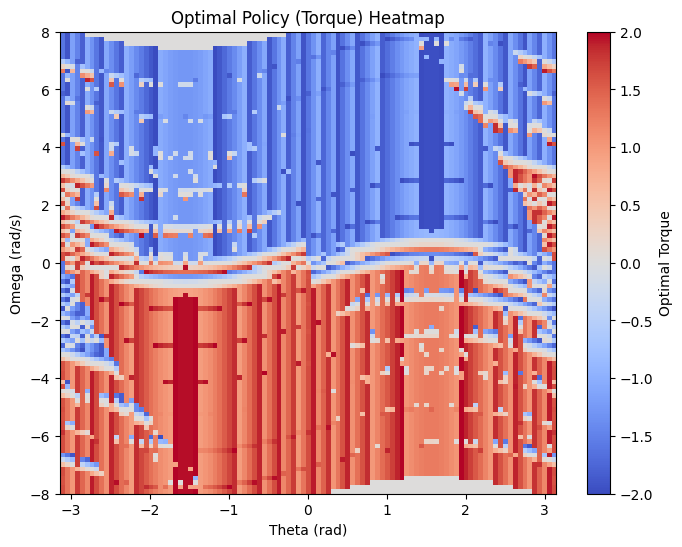

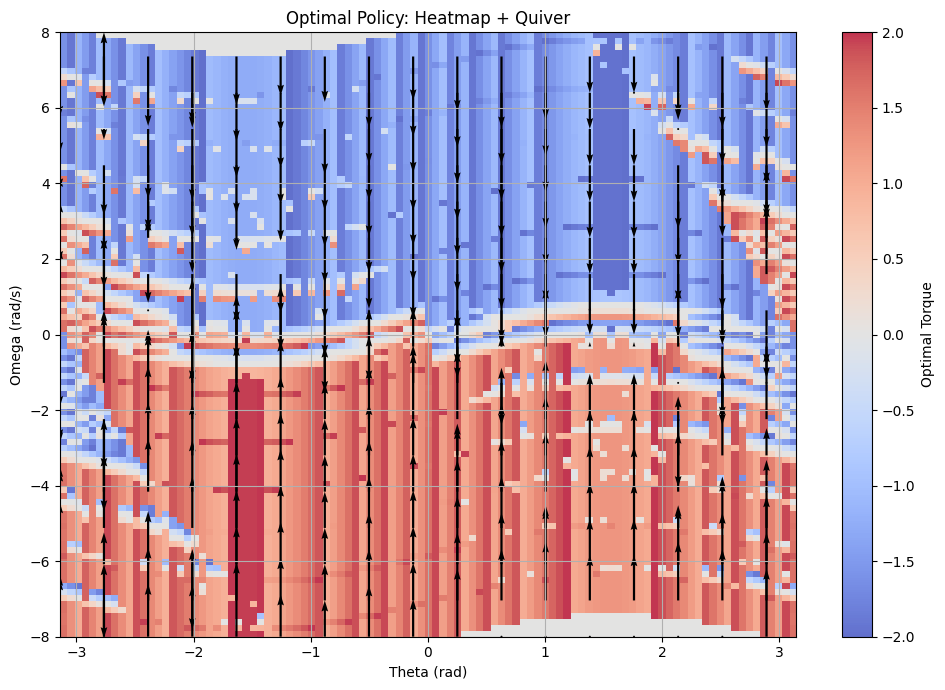

In [3]:
# 실행 및 시각화
if __name__ == "__main__":
    pendulum_dp = PendulumDP()
    V, policy = pendulum_dp.value_iteration(max_iters=500)

    # 최적 정책 시각화
    pendulum_dp.plot_policy()
    pendulum_dp.plot_policy_heatmap_quiver()

    

Total reward from policy: -162.47


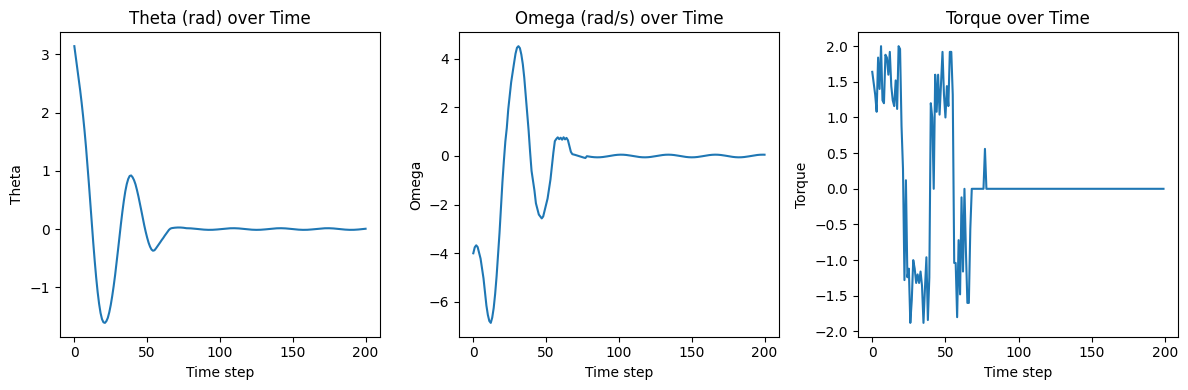

In [5]:

theta_traj, omega_traj, torque_traj = run_policy(pendulum_dp, policy, pendulum_dp.torque_space,theta_init=np.pi, omega_init=-4)

# Trajectory 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(theta_traj)
plt.title("Theta (rad) over Time")
plt.xlabel("Time step")
plt.ylabel("Theta")

plt.subplot(1, 3, 2)
plt.plot(omega_traj)
plt.title("Omega (rad/s) over Time")
plt.xlabel("Time step")
plt.ylabel("Omega")

plt.subplot(1, 3, 3)
plt.plot(torque_traj)
plt.title("Torque over Time")
plt.xlabel("Time step")
plt.ylabel("Torque")

plt.tight_layout()
plt.show()